In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import time
import squarify

# Calculate RFM

In [ ]:
df = pd.read_csv('df_RFM.csv')

In [ ]:
df.head(3)

,Member_number,Recency,Frequency,Monetary
0,2433,3,31,375.31
1,2193,91,27,361.45
2,1793,26,25,345.10


# Data Preprocess

In [ ]:
r_labels = range(4, 0, -1) # số ngày tính từ lần cuối mua hàng lớn thì gán nhãn nhỏ, ngược lại thì nhãn lớn
f_labels = range(1, 5)
m_labels = range(1, 5)

In [ ]:
[*r_labels]

[4, 3, 2, 1]

In [ ]:
r_groups = pd.qcut(df['Recency'].rank(method='first'), q=4, labels=r_labels)
f_groups = pd.qcut(df['Frequency'].rank(method='first'), q=4, labels=f_labels)
m_groups = pd.qcut(df['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [ ]:
df_RFM = df.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head(3)

,Member_number,Recency,Frequency,Monetary,R,F,M
0,2433,3,31,375.31,4,4,4
1,2193,91,27,361.45,3,4,4
2,1793,26,25,345.10,4,4,4


In [ ]:
def join_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)

In [ ]:
df_RFM.head(3)

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment
0,2433,3,31,375.31,4,4,4,444
1,2193,91,27,361.45,3,4,4,344
2,1793,26,25,345.10,4,4,4,444


In [ ]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()

In [ ]:
print(rfm_count_unique.sum())

60


In [ ]:
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head(3)

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,2433,3,31,375.31,4,4,4,444,12
1,2193,91,27,361.45,3,4,4,344,11
2,1793,26,25,345.10,4,4,4,444,12


# MODEL TRAINING & PREDICTION

In [ ]:
def rfm_level(df):
    #new customer
    if df['R'] == 1 and df['F'] == 1:
        return "New"
    elif df['R'] == 4 :
        return 'Risk'
    elif df['R'] > 2 and (df['F'] == 4 or df['M'] == 4):
        return 'Vip'
    else:
        return 'Normal'

In [ ]:
start_time = time.time()
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
end_time = time.time()

print ("model training time:",0.000,"sec")
print ("Prediction time:", round(end_time-start_time,3),"sec")

model training time: 0.0 sec
Prediction time: 0.05 sec


# Evaluation

In [ ]:
df_RFM.head(3)

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,2433,3,31,375.31,4,4,4,444,12,Risk
1,2193,91,27,361.45,3,4,4,344,11,Vip
2,1793,26,25,345.10,4,4,4,444,12,Risk


In [ ]:
df_RFM['RFM_Level'].value_counts()

RFM_Level
Normal    2045
Risk       975
New        481
Vip        397
Name: count, dtype: int64

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [ ]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,New,458.0,4.0,34.0,481,12.34
1,Normal,218.0,9.0,75.0,2045,52.46
2,Risk,28.0,12.0,108.0,975,25.01
3,Vip,98.0,16.0,146.0,397,10.18


In [ ]:

X = df_RFM[["Recency", "Frequency", "Monetary"]].values

# Chuyển RFM_Level từ string sang số để tính score
le = LabelEncoder()
labels = le.fit_transform(df_RFM["RFM_Level"])

# Silhouette Score
sil_score = silhouette_score(X, labels)
print("Silhouette Score:", round(sil_score, 2))

# Davies-Bouldin Index
dbi = davies_bouldin_score(X, labels)
print("Davies-Bouldin Index:", round(dbi, 2))

Silhouette Score: 0.12
Davies-Bouldin Index: 1.1


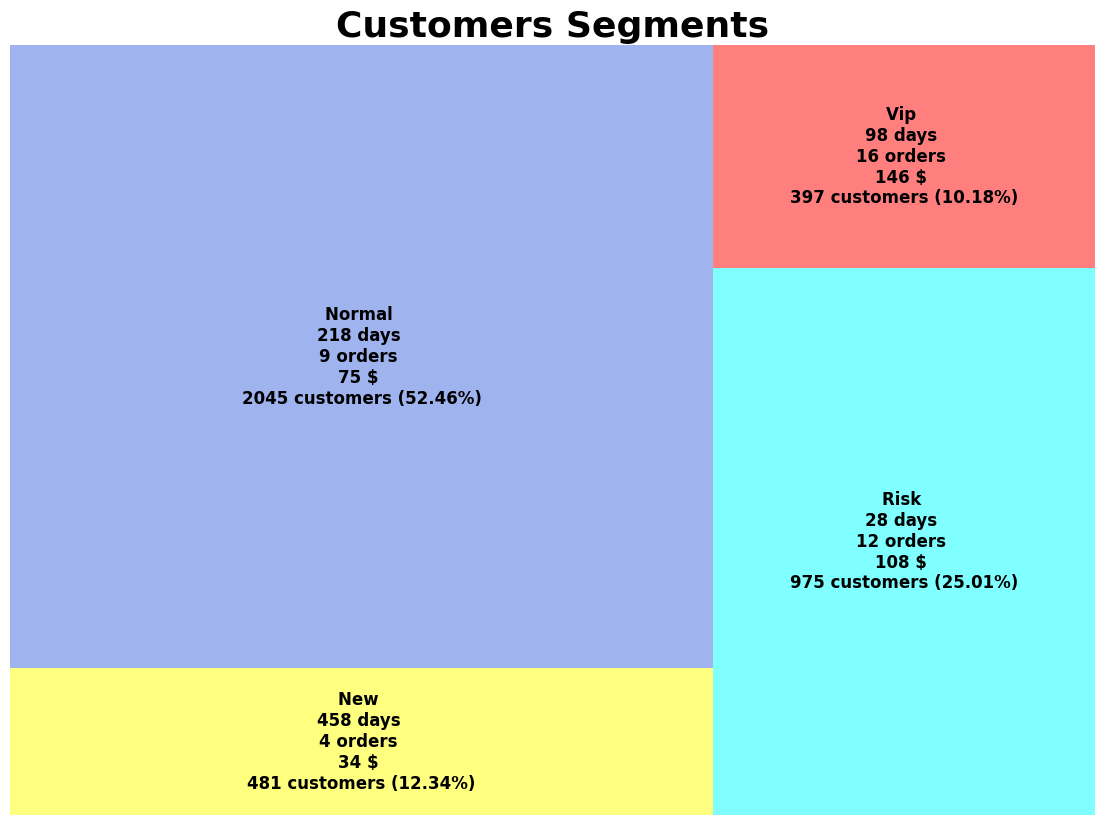

In [ ]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'NEW':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.show()

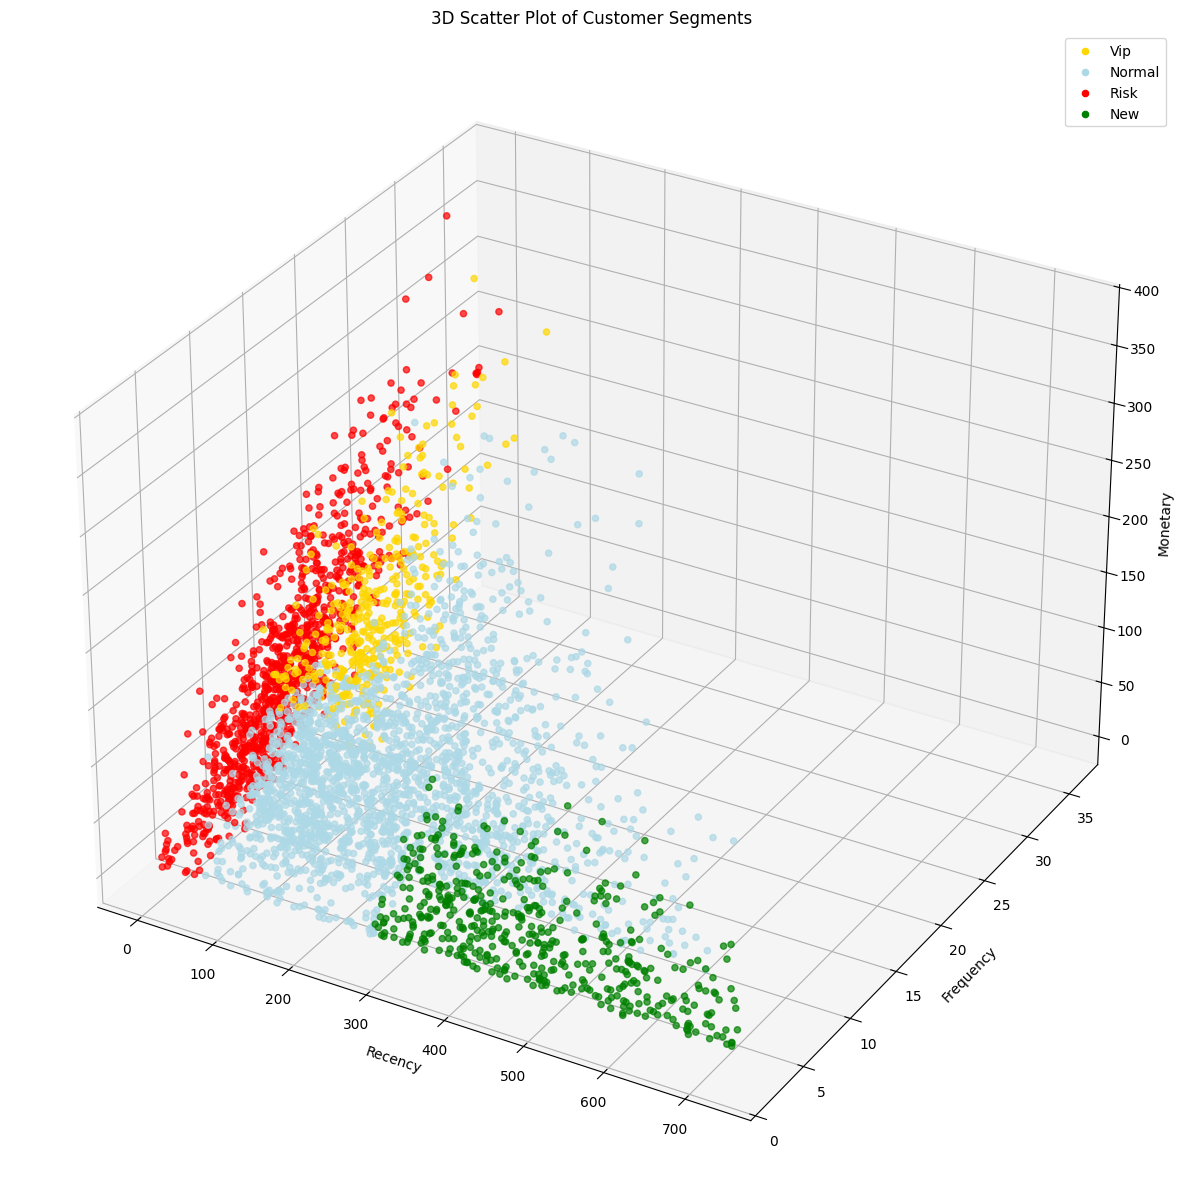

In [ ]:
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')

x = df_RFM['Recency']
y = df_RFM['Frequency']
z = df_RFM['Monetary']

color_map = {
    'Vip': 'gold',
    'Normal': 'lightblue',
    'Risk': 'red',
    'New': 'green'
}

# Apply colors based on the 'Level' column
colors = df_RFM['RFM_Level'].map(color_map).values


# Scatter plot with different colors for different levels
scatter = ax.scatter(x, y, z,c=colors, alpha=0.7)

# Add labels for axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
for level, color in color_map.items():
    ax.scatter([], [], color=color, label=level)  # Empty scatter to represent the legend item

# Add the legend with proper labels
ax.legend(title="Customer Segments")


ax.legend()

# Add a title
plt.title('3D Scatter Plot of Customer Segments')

# Show the plot
plt.show()

In [ ]:
**comment:**
Segments are clearly separable in the 3D RFM space.
Rule-based segmentation provides a quick and intuitive way to understand customer behavior.

Helpful for direct action strategies like:

    Targeting Risk customers for win-back offers

    Nurturing New customers into frequent buyers

    Rewarding Vip customers